In [1]:
import cv2
import glob
import numpy as np
print("OpenCV version :  {0}".format(cv2.__version__))

OpenCV version :  4.2.0


# Step 1 Load the image pair and camera parameters.

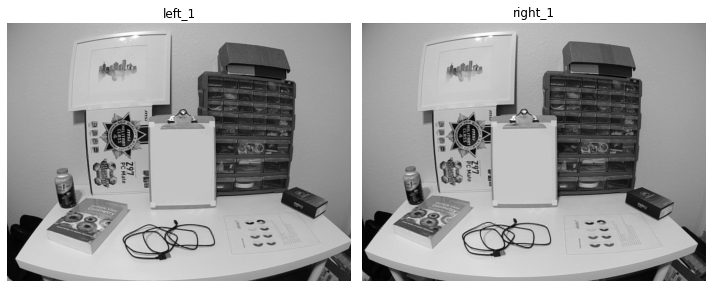

In [2]:
# 0 for grayscale
left_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/left_*.png"))]
right_ = [cv2.imread(image, 0) for image in sorted(glob.glob("../../images/task_7/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

## Camera parameter matrices

In [3]:
left_intrinsic = np.array([[423.27381306, 0, 341.34626532],
                           [0, 421.27401756, 269.28542111],
                           [0, 0, 1]])

right_intrinsic = np.array([[420.91160482, 0, 352.16135589],
                            [0, 418.72245958, 264.50726699],
                            [0, 0, 1]])

distCoeffs_left = np.array([-0.43394157423038077, 0.26707717557547866,
                             -0.00031144347020293427, 0.0005638938101488364,
                             -0.10970452266148858])
distCoeffs_right = np.array([-0.4145817681176909, 0.19961273246897668,
                             -0.00014832091141656534, -0.0013686760437966467,
                             -0.05113584625015141])

# Step 2 Detect, match, and associate features on the image pair.

## First, undistort the images

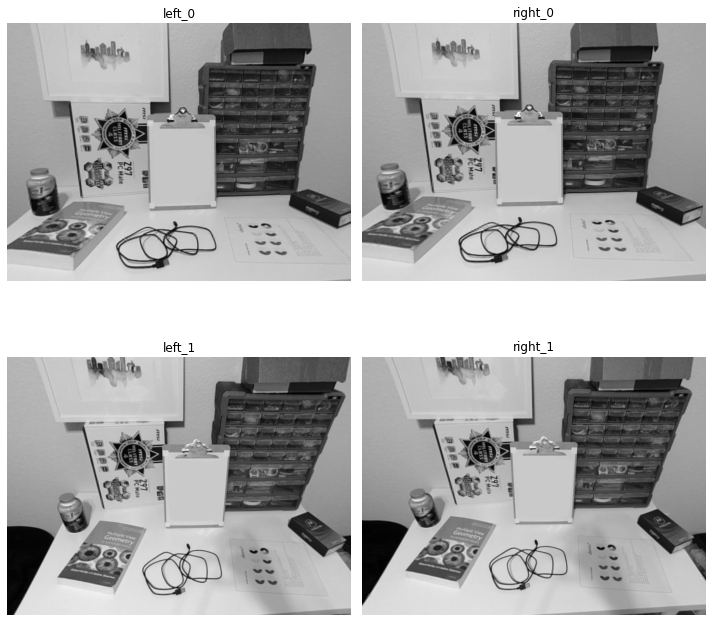

In [4]:
def undistortImage(img, mtx, distCoeffs):
    h,  w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,distCoeffs,(w,h),0,(w,h))   # warp=0

#     dst = cv2.undistort(img, mtx, distCoeffs, None, newcameramtx)

    mapx, mapy = cv2.initUndistortRectifyMap(left_intrinsic, distCoeffs_left, None, newcameramtx, (w,h), 5)
    dst = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)

    # crop the image
    x,y,w,h = roi
    return dst[y:y+h, x:x+w]

for i in range(len(left_)):
    left_[i] = undistortImage(left_[i], left_intrinsic, distCoeffs_left)

for i in range(len(right_)):
    right_[i] = undistortImage(right_[i], right_intrinsic, distCoeffs_right)
    
plot_figures({'left_0': left_[0], 'right_0': right_[0], 'left_1': left_[1], 'right_1': right_[1]}, 2, 2)

## Get ORB features

In [5]:
img_left = left_[0].copy()
img_right = right_[0].copy()

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp_left = orb.detect(img_left,None)
kp_right = orb.detect(img_right,None)

# compute the descriptors with ORB
kp_left, des_left = orb.compute(img_left, kp_left)
kp_right, des_right = orb.compute(img_right, kp_right)

## Filter the feature points

In [6]:
import math
def euclidean_dist(pt1, pt2):
    return math.sqrt((pt2[0]-pt1[0])**2 + (pt2[1]-pt1[1])**2)

def filter_kp(kp, distance=8):
    l = []

    for i in range(len(kp)-2):
        for j in range(i+1,len(kp)-2):
            if euclidean_dist(kp[i].pt,kp[j].pt) < distance:
                # keep the point with the higher response value
                if kp[i].response > kp[j].response:
                    l.append(j)
                else:
                    l.append(i)
                    j = len(kp)

    l = list(dict.fromkeys(l))
    l = sorted(l, reverse=True)
#     print('l: ', l)
    # remove items
    for i in l:
        kp.pop(i)
    
    return kp

In [7]:
len(kp_right)
#print(kp_right)

500

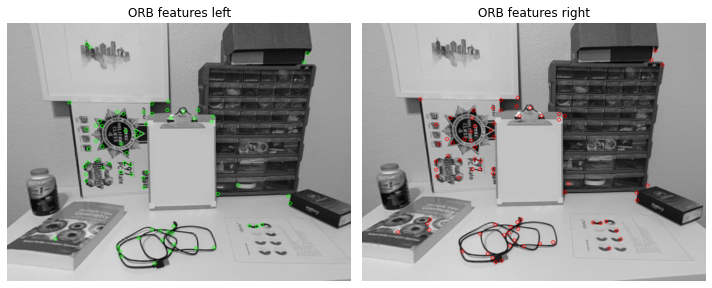

In [8]:
kp_left_filtered = filter_kp(kp_left.copy())
kp_right_filtered = filter_kp(kp_right.copy())


img_left_pts = cv2.drawKeypoints(img_left.copy(), kp_left_filtered, outImage = None, color=(0,255,0))
img_right_pts = cv2.drawKeypoints(img_right.copy(), kp_right_filtered, outImage = None, color=(255,0,0))

plot_figures({'ORB features left':img_left_pts, 'ORB features right':img_right_pts},1,2)

In [9]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des_left,des_right)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

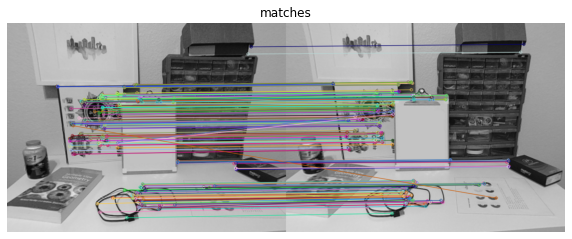

In [10]:
# draw all matches
img3 = cv2.drawMatches(img_left,kp_left,img_right,kp_right,matches[:], None,flags=2)

plot_figures({'matches':img3})

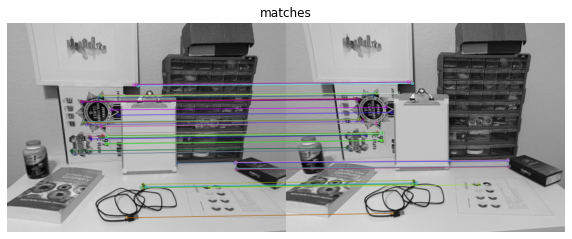

In [11]:
# Draw first 50 matches.
img3 = cv2.drawMatches(img_left,kp_left,img_right,kp_right,matches[:50], None,flags=2)

plot_figures({'matches':img3})

In [12]:
print(matches[0])

<DMatch 0x7efba4062710>


# Step 3 Calculate the essential matrix between the image pair.

## Attempt 1

In [13]:
# select points to evaluate the fundamental matrix
pts1 = []
pts2 = []
idx = matches[1:20]

for i in idx:
    pts1.append(kp_left[i.queryIdx].pt)
    pts2.append(kp_right[i.trainIdx].pt)

pts1 = np.array(pts1)
pts2 = np.array(pts2)

# creating homegeneous coordenate
pones = np.ones((1, len(pts1))).T

pth_1 = np.hstack((pts1, pones))
pth_2 = np.hstack((pts2, pones))

In [14]:
# evaluate the essential Matrix (using the original points, not the normilized ones)
E, mask0 = cv2.findEssentialMat(pts1, pts2)
# evaluate the fundamental matrix (using the normilized points)
F, mask = cv2.findFundamentalMat(pts1, pts2)

E = np.mat(E)
F = np.mat(F)

In [15]:
def drawlines(img1, img2, lines, pts1, pts2):
    """ img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines """
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
    return img1, img2

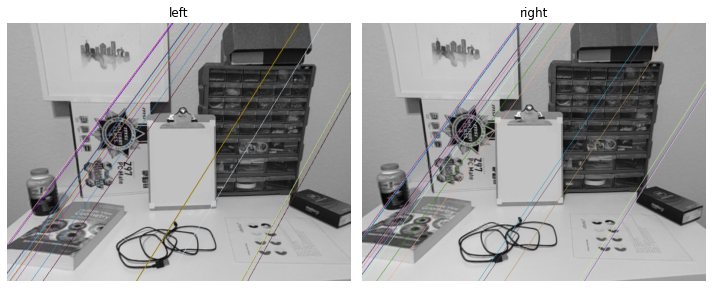

In [16]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img_left, img_right, lines1, pts1, pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img_right, img_left, lines2, pts2, pts1)
plot_figures({'left':img5, 'right': img3}, 1, 2)

## Attempt 2

In [17]:
#extract float coordinates for keypoints
pts_left = np.array([kp_left[i].pt for i in range (len(kp_left))])
pts_right = np.array([kp_right[i].pt for i in range (len(kp_right))])

Emat, Emask = cv2.findEssentialMat(pts_left, pts_right)
Fmat, Fmask = cv2.findFundamentalMat(pts_left, pts_right)

print(Emat)
print(Fmat)

[[ 0.04955573 -0.03561738 -0.54661372]
 [-0.0417195   0.03009804  0.44141303]
 [ 0.55240899 -0.43414827  0.07972954]]
[[ 1.81957905e-05 -8.16173815e-06 -1.77614123e-03]
 [-3.76927183e-06  1.84970677e-05 -3.18046880e-03]
 [-2.84004764e-03 -2.14939039e-03  1.00000000e+00]]


In [18]:
# select inliner points
mask_pts_left = pts_left[Emask.ravel() == 1]
mask_pts_right = pts_right[Emask.ravel() == 1]

In [19]:
def drawlines(img1, img2, lines, pts1, pts2):
    """ img1 - image on which we draw the epilines for the points in img2
    lines - corresponding epilines """
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
    return img1, img2

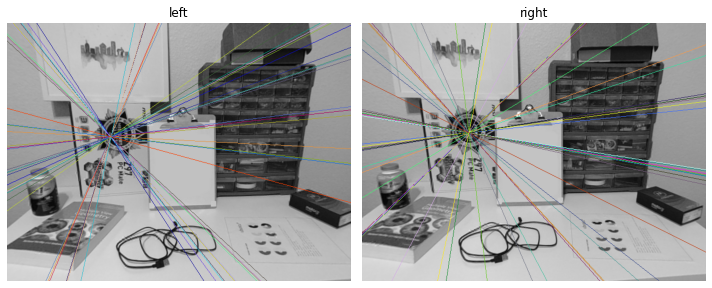

In [20]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(mask_pts_right.reshape(-1, 1, 2), 2, Fmat)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img_left, img_right, lines1, mask_pts_left, mask_pts_right)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(mask_pts_left.reshape(-1, 1, 2), 1, Fmat)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img_right, img_left, lines2, mask_pts_right, mask_pts_left)
plot_figures({'left':img5, 'right': img3}, 1, 2)